#Shape detection experiment [AlexNet, VGG19, ResNet152V2, DenseNet201]
In this part of the experiment we will take a look at the predictions we have obtained with the different models and we will compare them. 

**A clarification**: the training phase was not pushed, probably from each of the models more could be achieved. The experiment was built for two reasons: basing the pipeline to implement different CNN models and comparing their performance by recognizing some of their trends. For this I have used only 16 thousand examples. Certainly with more examples in training phase each of the neural networks would have achieved better performance (as I was able to verify with 35 thousand examples), but this would have prevented seeing the different behaviors of the networks (especially for VGG19, ResNet and DenseNet).

The structure of this Part of the experiment is as follows:
___

###Part III
- Loading data and model selection
- Make prediction and analysis
  - Confidence task
  - Classification task
  - Bounding boxes task
- Conclusions
___

#Part III


In [0]:
# Import some useful library
from google.colab import drive
import h5py
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

# Import matplotlib functionality 
import matplotlib.pyplot as plt
from matplotlib import gridspec, patches
from matplotlib.colors import ListedColormap

##Loading data
We load the Test-set and the neural network model for which we want to see the performances

In [0]:
# mount our workdrive
drive.mount('/content/drive')

In [0]:
# general path 
path = '/content/drive/My Drive/'
# data path with datasets names
data_path = 'Colab_data/'
data_name = 'XYdata_40k_3bb_testset.h5'

Loading Test-set.

In [0]:
# open data file
xy_h5f = h5py.File(path + data_path + data_name, 'r')

# load data
X_test = np.array(xy_h5f['X_test'])
Y_test = np.array(xy_h5f['Y_test'])
imgs_mean = np.array(xy_h5f['imgs_mean'])
imgs_std = np.array(xy_h5f['imgs_std'])

In [0]:
# close data file
xy_h5f.close()

Let's consider some useful information from our dataset:

In [166]:
# Useful informations about data images 
n_examples = X_test.shape[0]    # number of examples in Test-set
side_dim = X_test.shape[1]      # side dimension for each image
n_bb = Y_test.shape[1] // 6     # bounding boxes for each image

print('Test examples:', X_test.shape[0])
print('Image size:', side_dim, 'x', side_dim)
print('Bounding boxes per image:', n_bb)
print('-------')
print('Images mean:', imgs_mean)
print('Images standard deviation:', imgs_std)

Test examples: 6000
Image size: 64 x 64
Bounding boxes per image: 3
-------
Images mean: 196.2765323384603
Images standard deviation: 18.37592427614397


In [0]:
# possible objects classes in the images 
classes = { 0: '--',  # no-obj, or background-obj 
            1: '+r',  # red cross
            2: '+g',  # green cross
            3: '+b',  # blue cross
            4: '#r',  # red pound 
            5: '#g',  # green pound
            6: '#b',  # blue pound
            7: 'or',  # red square
            8: 'og',  # green square
            9: 'ob',  # blue square
          }

## CNN model selection

Before starting here is a brief description of the neural networks that we are going to test:

- The Test Model is not a true deep neural network model (in fact it only has two layers). Above all, it does not use Convolutional layers (it is not a CNN). I created it to build the pipeline and to have a comparison with other networks.
- **AlexNet** is an eight-layer neural network designed by [Alex Krizhevsky in 2012](http://www.cs.toronto.edu/~hinton/absps/imagenet.pdf) very [important in the history of CNN development]((https://en.wikipedia.org/wiki/AlexNet). It demonstrated how the use of Convolutional Neural Networks could brilliantly solve image classification tasks, providing appreciable results compared to other machine learning techniques. There is no officially released version of AlexNet (not at least on TensorFlow), the following is a personal reconstruction of it.
- **VGG19** is a 19-layer neural network that saw its appearance in 2014 (although [the paper by its creators Simonyan & Zisserman](https://arxiv.org/abs/1409.1556) was published the following year). It introduced the importance of depth for CNNs. 
- Appeared in 2015, **ResNet** ([He at al.](https://arxiv.org/abs/1512.03385)) has significantly expanded the intuition of VGG by bringing the depth of the neural network up to 152 layers - and solving the age-old problem of vanishing gradient by introducing the concept of residual block. 
- Introduced in 2017 ([Huang et al.](https://arxiv.org/abs/1608.06993)), **DenseNet** takes inspiration from Resnet and introduces the Dense-blocks in which the layers are connected to each other in feedforward fashion. It has the characteristic of further alleviating vanishing gradient, strengthens feature propagation and encourages feature reuse. The depth of the net in this case exceeds 200 layers.

But before let's create an additional model that we will use as a benchmark. It is actually a model that provides us with completely random results for each of the tasks.

In [0]:
# Random Model
class Random_model():
  def __init__(self, n_examples, n_bb):
    self.n_examples = n_examples
    self.n_bb = n_bb

  def predict(self, X):
    classes = np.random.random(size=(self.n_examples, self.n_bb, 10))
    confidence = np.random.random(size=(self.n_examples, self.n_bb)) * 2 - 1 # *Remember: we use tanh as activaion function for CNN
    coords = np.random.randint(64, size=(self.n_examples, self.n_bb*4))
    predictions = [classes, confidence, coords]
    return predictions

  def summary(self):
    print('Prediction size')
    print(' - class prediction =', n_examples, 'x', n_bb, 'x 10')
    print('   values range: 0-9')
    print(' - confidence prediction =', n_examples, 'x', n_bb)
    print('   values range: 0-1')
    print(' - class prediction =', n_examples, 'x', n_bb*4)
    print('   values range: 0 -',side_dim)

Definition of the custom loss function for the coordinates.

In [0]:
# coordinates loss function
def rmse(y_true, y_pred):
  '''  
  Arguments:
  y_true -- tensor with expected Y
  y_pred -- tensor with predicted Y
  
  Returns:
  euc_dist -- scalar
  '''
  rmse = K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))
  return rmse

Loading CNN model.

In [0]:
def select_model(model_name):
  if model_name == 'Test':
    model_name += ' - Flat model - not a CNN'
    model_filename = path + model_path + 'test_16k_3bb_100_ep.h5'
  elif model_name == 'AlexNet':
    model_filename = path + model_path + 'AlexNet_16k_3bb_30_ep.h5'
  elif model_name == 'VGG19':
    model_filename = path + model_path + 'VGG19_16k_3bb_35ep.h5'
  elif model_name == 'ResNet':
    model_filename = path + model_path + 'ResNet152V2_16k_3bb_35ep.h5'
  elif model_name == 'DensNet':
    model_filename = path + model_path + 'DenseNet201_16k_3bb_35ep.h5'
  else:
    print('Selected model: Random Model')
    return Random_model(n_examples, n_bb)

  print('Selected model', model_name)
  # load model
  model = keras.models.load_model(model_filename, custom_objects={'rmse': rmse})

  return model

In [0]:
# model path with models names
model_path = 'Colab_models/'
model_name = 'RandomModel' # 'RandomModel' # 'Test' # 'AlexNet' # 'VGG19' # 'ResNet' # 'DensNet' #

In [188]:
# clear ghraph
tf.keras.backend.clear_session()

# model selection
model = select_model(model_name)

Selected model: Random Model


We take a look at the neural network.

In [14]:
# the structure of the model
model.summary()

Model: "test"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 12288)        0           input_1[0][0]                    
__________________________________________________________________________________________________
No_Model (BatchNormalization)   (None, 12288)        49152       flatten[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           368670      No_Model[0][0]                   
_______________________________________________________________________________________________

## Make predictions


In [0]:
# Predictions from neural network using Test set as input
model_predictions = model.predict(X_test)

Let's break down the predictions and see how the different models of neural network have behaved in each of the three tasks on which we have trained them: obj presence confidence, classification of the identified object and identification of the bounding boxes.

In [0]:
# decompose predictions by different targets (class, confidence, coordinates)
predict_class = model_predictions[0].reshape(n_examples, n_bb, -1)
predict_confidence = model_predictions[1].reshape(n_examples, -1, 1) / 2 + (1/2) # *Remember: we use tanh as activation function 
predict_bboxes = model_predictions[2].reshape(n_examples, n_bb, -1)              

In [191]:
# reshape and convert softmax data to class prediction  
predict_class = predict_class.argmax(-1).reshape(n_examples, n_bb, 1)

# shape of prediction for class, confidence and bboxes coordinates
predict_class.shape, predict_confidence.shape, predict_bboxes.shape

((6000, 3, 1), (6000, 3, 1), (6000, 3, 4))

Now let's go into detail and generalize the behavior of the different models on the whole Test-set for all three tasks.


## Confidence Predictions
Let's consider confidence predictions. This measure should tell us if an object is present or not in the bounding boxing under consideration (more properly it tells us for every bounding boxes if there is an object in the image to be examined and looked for).

In [0]:
# True and Predict value for level of confidence
true_confidence = Y_test[:, 1::6].reshape(-1)
pred_confidence = predict_confidence.reshape(-1)

For our purpose, the degree of confidence assumes binary values. We can therefore make a rounding for the intermediate values so as to fall into them: '0' - no confidence, '1' - total confidence.
(Wanting to do a more in-depth analysis we could later analyze the distribution of predictions and better understand the behavior of confidence the neural network. At the moment this is beyond the scope of our experiment)

In [0]:
# now we consider the strictly and almost equivalence of confidence
src = (pred_confidence == true_confidence)
arc = (np.round(pred_confidence) == np.round(true_confidence))

strictly_right_confidence = np.count_nonzero(src)
almost_right_confidence = np.count_nonzero(arc)

# to see the confidence accuracy we just need the almost results
confidence_accuracy = almost_right_confidence / (n_examples*n_bb)
# Let's also take a look at the strictly confidence accuracy
strictly_confidence_accuracy = strictly_right_confidence / (n_examples*n_bb)

Now let's see the behavior of each model:

In [0]:
# Random Model (random predictions - no params x no layers)
print('Strictly confidence accuracy:', strictly_confidence_accuracy)
print('Confidence accuracy:', confidence_accuracy)

Strictly confidence accuracy: 0.0
Confidence accuracy: 0.5046111111111111


As was to be expected, the random model provides approximately 50% probability of obtaining the correct confidence value. Furthermore, with the numpy function used (random.random) it is rather unlikely to have 0 or 1 between the predictions (the values are practically all rational between 0 and 1) for this reason the Strictly confidence accuracy is equal to zero.

In [17]:
# Test (Flat model, not a CNN - 602 params x 2 layers)
print('Strictly confidence accuracy:', strictly_confidence_accuracy)
print('Confidence accuracy:', confidence_accuracy)

Strictly confidence accuracy: 0.23755555555555555
Confidence accuracy: 0.8050555555555555


However simple, the Test model performs better: in over two cases out of ten it provides a strictly correct value and by widening the mesh it reaches an accuracy of almost 80%.

In [49]:
# MyAlexNet (48.2M params x 8 layers)
print('Strictly confidence accuracy:', strictly_confidence_accuracy)
print('Confidence accuracy:', confidence_accuracy)

Strictly confidence accuracy: 0.2818333333333333
Confidence accuracy: 0.8867222222222222


AlexNet improves performance compared to our naive Test model. The detection of confidence has a marked improvement - more then 8 percentage points. However, it is achieved with the help of 48M of parameters (compared to 602 of the Test model) and much greater calculation resources. 

In [92]:
# VGG19 (20.4M params x 19 layers)
print('Strictly confidence accuracy:', strictly_confidence_accuracy)
print('Confidence accuracy:', confidence_accuracy)

Strictly confidence accuracy: 0.003833333333333333
Confidence accuracy: 0.8996666666666666


We reach a confidence of almost 90% with VGG19. The network does not identify the '0' and the '1' in a clear way - only after an approximation as tell us the Strictly confidence accuracy close to 0.

In [113]:
# Resnet152V2 (58.7M params x 152 layers')
print('Strictly confidence accuracy:', strictly_confidence_accuracy)
print('Confidence accuracy:', confidence_accuracy)

Strictly confidence accuracy: 0.11511111111111111
Confidence accuracy: 0.9115


With the ResNet we do even better. The confidence accuracy reaches over 91%. 

In [135]:
# DenseNet201 (7.2M params x 201 layers)
print('Strictly confidence accuracy:', strictly_confidence_accuracy)
print('Confidence accuracy:', confidence_accuracy)

Strictly confidence accuracy: 5.555555555555556e-05
Confidence accuracy: 0.957


...and with DensNet we reach almost 96%. The tendency to have few values strictly 0 or strictly 1 reaches its climax here.

##More in detail
Let's go a little more in detail by displaying the distribution of the confidence level of the predictions with respect to the true values.

In [0]:
# let's create some mask
# obj not created, obj not to detect (non_obj), obj created
c_zero = (true_confidence == 0)
c_non_obj = (true_confidence == .1)
c_one = (true_confidence == 1)

# strictly obj confidence 
right_c_zero = np.count_nonzero(src * c_zero)
right_c_one = np.count_nonzero(src * c_one)

# almost obj confidence
almost_zero = np.count_nonzero(arc * c_zero) + np.count_nonzero(arc * c_non_obj)
almost_one = np.count_nonzero(arc * c_one)

# wrong confidence prediction
wrong_prediction = (n_examples*n_bb) - np.count_nonzero(arc)

# confidence original/predicted data
confidence_original_data = [c_zero, c_non_obj, c_one]

confidence_predicted_data= [right_c_zero,
                           almost_zero-right_c_zero, 
                           wrong_prediction,
                           almost_one-right_c_one,
                           right_c_one]

# confidence confusion matrix / recall / precision / f1_score
y_true = true_confidence.astype('int16')
y_pred = np.round(pred_confidence).astype('int16')

confidence_confusion_matrix = confusion_matrix(y_true, y_pred)

In [0]:
# method to show some data about confidence results
def plot_confidence_data(original_data, 
                        predicted_data, 
                        almost_right_confidence,
                        cc_matrix):
  """
  """
  # Plot true confidence distribution vs predict confidence distribution
  fig = plt.figure(figsize=(12,6))
  plt.title('obj confidence distribution')
  plt.axis('off')

  gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[5, 5, .4, 3]) 
  ax1 = fig.add_subplot(gs[0])
  ax2 = fig.add_subplot(gs[1])
  ax3 = fig.add_subplot(gs[3])

  # pie with objects above_pc_obj, below_pc_obj and no_obj
  ax1.set_title('Real objects distribution')
  explode = [0, 0, 0.1]
  ax1.pie([np.count_nonzero(original_data[0]), # c_zero 
          np.count_nonzero(original_data[1]), # c_non_obj 
          np.count_nonzero(original_data[2])], # c_one 
          autopct='%1.1f%%', explode=explode, colors=[[.7, .4, .8],[.7, .2, .6],[.8, .4, .2]])
  ax1.legend(['objects not created',
              'objects below Pc_th',
              'object above Pc_th'], loc = 'lower left')

  # pie with objects above_pc_obj, below_pc_obj and no_obj
  ax2.set_title('Predict objects distribution')
  explode = [0, 0, .1, 0, 0]
  ax2.pie(predicted_data, 
          autopct='%1.1f%%', explode=explode, colors=[[.55, .45, .0],'y', 'r',[.2, .85, .1],'g'])
  ax2.legend(['right 0',
              'almost 0',
              'wrong', 
              'almost 1',
              'right 1'], loc = 'lower right')

  # confusion matrix
  ax3.set_title('Confusion matrix')
  cmap = 'cividis' #ListedColormap(['r',[.8, .5, .0],'y',[.5, .7, .0],'g'])
  ax3.imshow(cc_matrix, cmap=cmap)
  ax3.set_xlabel('predictions')
  ax3.set_xticks([0,1])
  ax3.set_xticklabels([0, 1])
  ax3.set_ylabel('true values')
  ax3.set_yticks([0,1])
  ax3.set_yticklabels([0, 1])
  for i in range(cc_matrix.shape[0]):
    for j in range(cc_matrix.shape[1]):
      ax3.text(j, 
               i, 
               cc_matrix[i,j], 
               color=[.8,.4,.1], 
               fontsize=14, 
               horizontalalignment='center',
               verticalalignment='bottom')
      if i == j:
        ax3.text(j, 
                 i, 
                 "{:.0%}".format(cc_matrix[i,j]/almost_right_confidence), 
                 color=[.8,.4,.1], 
                 fontsize=11, 
                 horizontalalignment='center',
                 verticalalignment='top')
  
  ax3.text(1.9, 0, 'Precision ' + "{:.2f}".format(confidence_precision),
        bbox={'facecolor': 'y', 'alpha': 0.15, 'pad': 3})
  ax3.text(1.9, .5, 'Recall ' + "{:.2f}".format(confidence_recall), style='italic',
        bbox={'facecolor': 'y', 'alpha': 0.15, 'pad': 3})
  ax3.text(1.9, 1, 'F1_Score ' +  "{:.2f}".format(confidence_f1_score), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.2, 'pad': 3})
  plt.show()

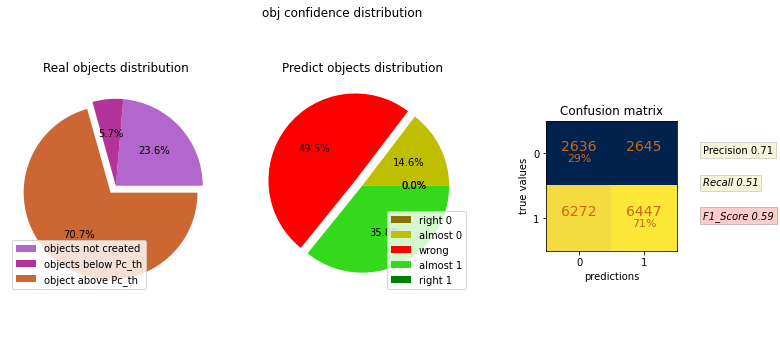

In [0]:
# Random Model (random predictions - no params x no layers)
plot_confidence_data(confidence_original_data, 
                    confidence_predicted_data,
                    almost_right_confidence, 
                    confidence_confusion_matrix)

As we have already seen, the random model gives us almost 50% of correct predictions. Of them the ratio between presence and absence of objects is almost the same compared to the real distribution of objects: more then 71% objects created and to be detected (**True Positive**), less then 29% of objects not created or with a low Pc_th (**True Negative**). As was to be expected the same ratio occurs between False Negatives and False Positives. 

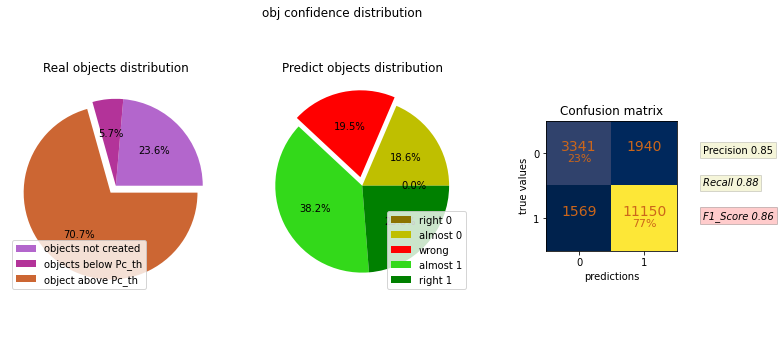

In [20]:
# Test (Flat model - not a CNN - 602 params x 2 layers)
plot_confidence_data(confidence_original_data, 
                    confidence_predicted_data,
                    almost_right_confidence, 
                    confidence_confusion_matrix)

The Test model performs much better, making only 19.5% error.  Identifying over 11.1k True Positive and over 3.3k True Negative out of the total of 18k cases. Compared to the real values, the relationship between the two in this case is shifted from the true positive side (77% compared to 23%). A trend that is accentuated by the slight abundance of False Positives compared to False Negatives - which brings greater recall than precision. From the pie of predictions distribution we also see that the model is not 'centered' on the values of 0 and 1 and it mostly provides values to be rounded to 0 (18.6%) and rounded to 1 (38.2%).

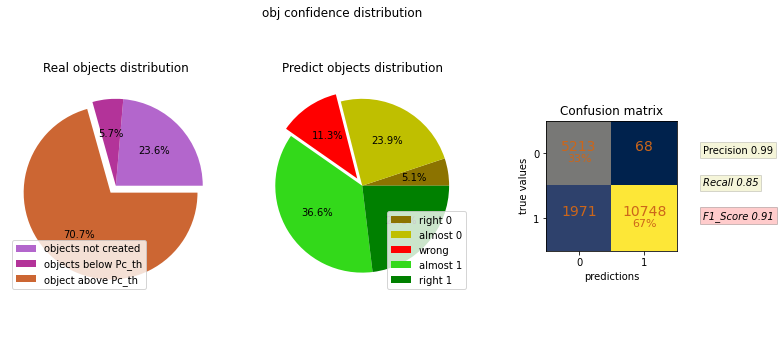

In [51]:
# MyAlexNet (48.2M params x 8 layers)
plot_confidence_data(confidence_original_data, 
                    confidence_predicted_data,
                    almost_right_confidence, 
                    confidence_confusion_matrix)

With AlexNet, the error in determining the presence of objects in an image drops to 11%. We improve the results obtained by the naive Test model, reversing the trend of errors with a very high precision (equal to .99) and a not so good recall (testifying to the high number of False Negatives). In the distribution pie we can also see that the model is less clear in identifying non-objects (the 'almost 0' compared to the '0') then the objects ('almost 1' compared to the '1'), but as we will see with the other models, it does not seem to be a true indication at all.

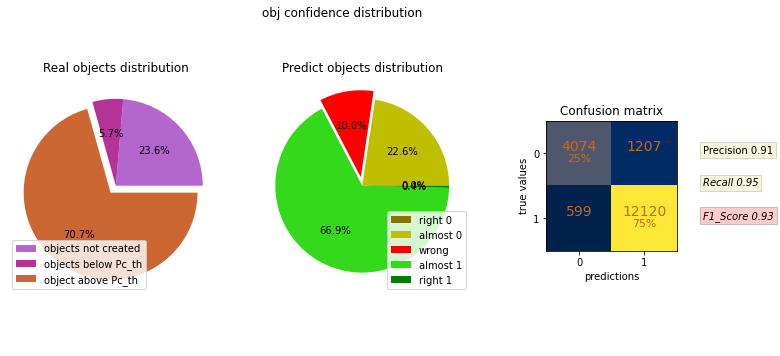

In [94]:
# VGG19 (20.4M params x 19 layers)
plot_confidence_data(confidence_original_data, 
                    confidence_predicted_data,
                    almost_right_confidence, 
                    confidence_confusion_matrix)

With the VGG19 we do not have a leap forward in the quality of the forecasts compared to AlexNet, but it is certainly an improvement that we can define significant considering the F1_score at .93. Note the reversal in the quality of the predictions with less False Negative (the recall rise to .95) than False Positive (precision at .91).

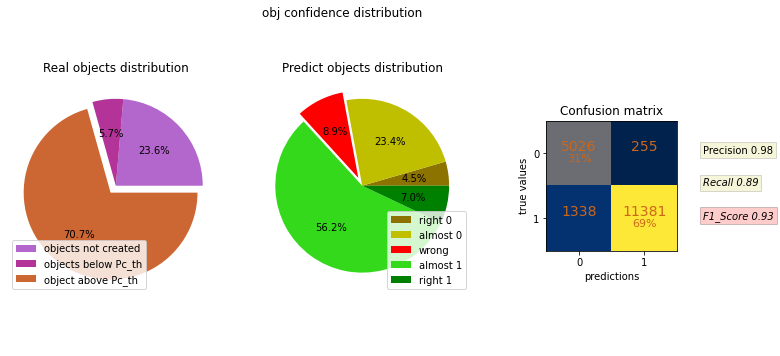

In [115]:
# Resnet152V2 (58.7M params x 152 layers)
plot_confidence_data(confidence_original_data, 
                    confidence_predicted_data,
                    almost_right_confidence, 
                    confidence_confusion_matrix)

As we already seen with VGG, in ResNet the reduction in the level of error corresponds to a lesser 'clarity' in establishing the confidence level ('almost 1' and 'almost 0' dominate the distribution pie). Compared to VGG19, Resnet has fewer False Positives than False Negatives and consequently a higher precision (about .98) than the recall (.89).

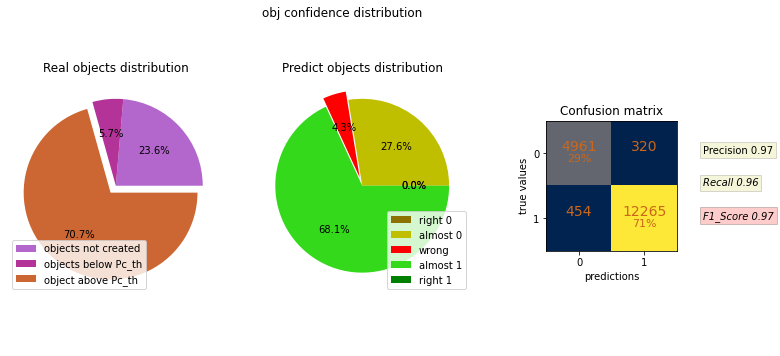

In [137]:
# DenseNet201 (7.2M params x 201 layers)
plot_confidence_data(confidence_original_data, 
                    confidence_predicted_data,
                    almost_right_confidence, 
                    confidence_confusion_matrix)

DenseNet has a behavior that can be called a middle ground between VGG19 and ResNet. Compared to previous neural networks, however, the performance on confidence detection definitely improves. In particular, it reduces the error to 4.3% by greatly reducing the False Positives compared to VGG19 and False Negative compared ResNet. The F1_scores reached .97(!).

## Class predictions
Now let's evaluate the predictions regarding the classification of the different objects, remember that we have nine classes (red cross, green cross, blue cross, red pound, green pound, blue pound, red square, green square, blue square) plus a tenth in case of background (when we have no objects or the objects belong to the background and on the basis of our Pc_th they don't have to be classified)

classes = {0: '---', 1: '+r', 2: '+g', 3: '+b', 4: '#r', 5: '#g', 6: '#b ', 7:' or ', 8:' og ', 9:' ob '}

In [0]:
true_class = Y_test[:, 0::6].reshape(-1).astype('int8')
pred_class = predict_class.reshape(-1).astype('int8') 

In [0]:
# Number of correctly classified objects (absolute and average value)
obj_to_identify = np.count_nonzero(true_class > 0)
obj_identified = np.count_nonzero((true_class == pred_class)*(true_class > 0))

# non-object correctly identify
nonobj_identified = np.count_nonzero((true_class == pred_class)*(true_class == 0))

# overall identification
overall_identification = np.count_nonzero(true_class == pred_class)

# Errors
wrong_classification = np.count_nonzero(true_class != pred_class)

# Accuracy
accuracy_obj_identified = obj_identified / np.count_nonzero(true_class > 0)
accuracy_overall_identified = overall_identification / (n_examples*n_bb)

In [0]:
# Random Model (random predictions - no params x no layers)
print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)))
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)),'\n')
print('Accuracy in obj identification:', accuracy_obj_identified)
print('Overall accuracy (considering non-obj):', accuracy_overall_identified)

Correct obj class identified: 1304 on 12719
Non-obj identified:  509 on 5281 

Accuracy in obj identification: 0.10252378331629845
Overall accuracy (considering non-obj): 0.10072222222222223


We get to the heart of the experiment with the detection of the classes. Our Random Model provides us with the statistical values of a random estimator. Considering that we have 9 + 1 classes it is obvious that it can identify the correct class once out of 10. This is in fact our accuracy.

In [23]:
# Test (Flat model - not a CNN - 602 params x 2 layers)
print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)))
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)),'\n')
print('Accuracy in obj identification:', accuracy_obj_identified)
print('Overall accuracy (considering non-obj):', accuracy_overall_identified)

Correct obj class identified: 2934 on 12719
Non-obj identified:  4482 on 5281 

Accuracy in obj identification: 0.2306785124616715
Overall accuracy (considering non-obj): 0.412


The Test model performs better, not only does it identify objects with an accuracy of .23 (about one every four/five) but it performs remarkably well in detecting non-objects - it does so in almost 85 percent of cases. This brings the overall accuracy to over 41 percent.

In [54]:
# MyAlexNet (48.2M params x 8 layers)
print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)))
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)),'\n')
print('Accuracy in obj identification:', accuracy_obj_identified)
print('Overall accuracy (considering non-obj):', accuracy_overall_identified)

Correct obj class identified: 10561 on 12719
Non-obj identified:  5246 on 5281 

Accuracy in obj identification: 0.8303325733155122
Overall accuracy (considering non-obj): 0.8781666666666667


As was to be expected with AlexNet we make a qualitative leap. Accuracy in object identification reaches nearly 83 percent, and it rises to over 87 percent taking into account the near-totality detection of non-objects. We are already at very high levels, non-objects have been identified in 99.3 percent of cases.

In [97]:
# VGG19 (20.4M params x 19 layers)
print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)))
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)),'\n')
print('Accuracy in obj identification:', accuracy_obj_identified)
print('Overall accuracy (considering non-obj):', accuracy_overall_identified)

Correct obj class identified: 11918 on 12719
Non-obj identified:  5258 on 5281 

Accuracy in obj identification: 0.9370233508923658
Overall accuracy (considering non-obj): 0.9542222222222222


The VGG19 raises an accuracy of over 93.7 percent rising to 95.4 percent considering the detection of non-objects. 

In [118]:
# Resnet152V2 (58.7M params x 152 layers)
print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)))
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)),'\n')
print('Accuracy in obj identification:', accuracy_obj_identified)
print('Overall accuracy (considering non-obj):', accuracy_overall_identified)

Correct obj class identified: 11158 on 12719
Non-obj identified:  5228 on 5281 

Accuracy in obj identification: 0.8772702256466703
Overall accuracy (considering non-obj): 0.9103333333333333


ResNet is not as good as VGG19 in class identification, the overall accuracy is still quite good (.91) but it is not excellent. A sensations I had during the training, ResNet has the potential to learn much more (compared to VGG19) but with a greater quantity of examples.

In [140]:
# DenseNet201 (7.2M params x 201 layers)
print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)))
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)),'\n')
print('Accuracy in obj identification:', accuracy_obj_identified)
print('Overall accuracy (considering non-obj):', accuracy_overall_identified)

Correct obj class identified: 11901 on 12719
Non-obj identified:  5241 on 5281 

Accuracy in obj identification: 0.9356867678276594
Overall accuracy (considering non-obj): 0.9523333333333334


With DenseNet we are again at the level of VGG19. 93.5 percent accuracy rising to over 95 percent considering non-objects.

##More in detail
We also go into more detail for this task. Let's look at the distribution of the classes predicted by neural networks and compare it with the real values.

In [0]:
# Precision, Recall, F1_score
c_report = classification_report(true_class, pred_class, target_names=list(classes.values()))
class_confusion_matrix = confusion_matrix(true_class, pred_class)

In [0]:
def plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix):
  cl = classes.values()
  ticks = np.arange(0,10)

  fig = plt.figure(figsize=(14,6))
  plt.axis('off')

  gs = gridspec.GridSpec(ncols=5, nrows=5, width_ratios=[1.1,.2,1.8,.3,.9]) 
  ax1 = fig.add_subplot(gs[1:4,0])
  ax2 = fig.add_subplot(gs[:,2])
  ax3 = fig.add_subplot(gs[:,4])

  # Plot Histogram obj classes distribution
  bins = np.arange(0, 11, 1)
  ax1.hist([true_class, pred_class], bins=bins-0.5, color=('y','g'))
  ax1.set(title='obj real classes / predictions', xlabel='classes', ylabel='num examples')
  ax1.set_xticks(ticks=bins) 
  ax1.set_xticklabels(cl)
  ax1.legend(['Real class','Predicted class'])

  # confusion matrix
  ax2.set_title('Confusion matrix')

  cmap = 'cividis'
  ax2.imshow(class_confusion_matrix, cmap=cmap)
  ax2.set_xlabel('predicted classes')
  ax2.set_xticks(ticks)
  ax2.set_xticklabels(cl)
  ax2.set_ylabel('true classes')
  ax2.set_yticks(ticks)
  ax2.set_yticklabels(cl)
  for i in range(class_confusion_matrix.shape[0]):
    for j in range(class_confusion_matrix.shape[1]):
      ax2.text(j, i ,class_confusion_matrix[i,j], color=[.8,.4,.1], fontsize=10, horizontalalignment='center',)

  ax3.axis('off')
  ax3.text(0.5, .5, c_report, wrap=True, horizontalalignment='center', verticalalignment='center', fontsize=12)
  plt.show()

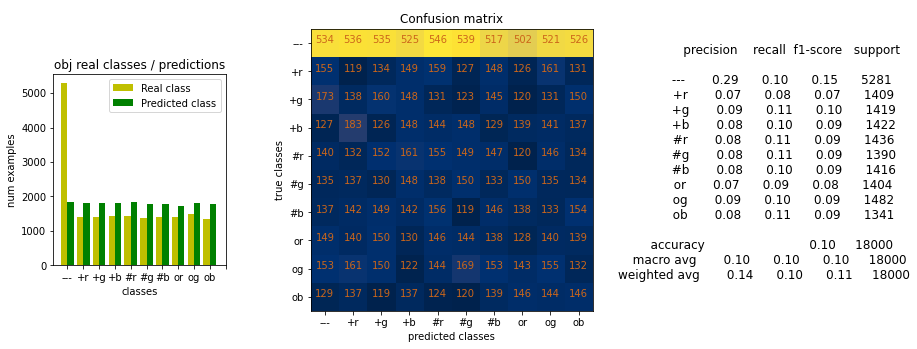

In [0]:
# Random Model (random predictions - no params x no layers)
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

As shown in the left histogram, the Random Model clearly provides predictions equally distributed across classes - including the background class. The result is an overabundance of False Positives among the non-objects identified as objects, evident in the first row of the confusion matrix, and an overall uniformity of values (except statistical oscillations) in the rest of the matrix. Accuracy as expected was 10 percent.

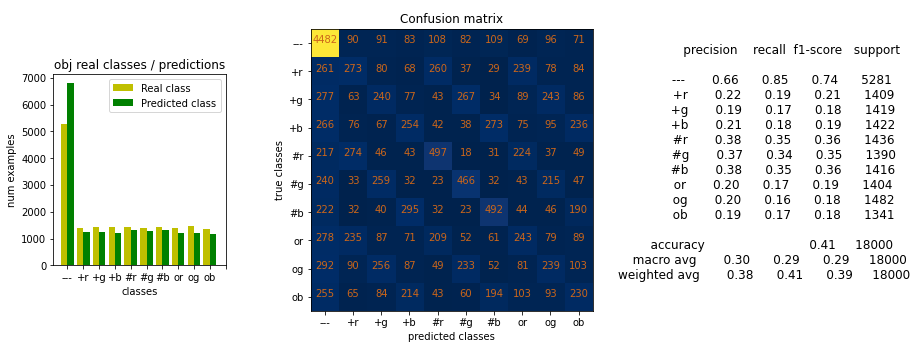

In [26]:
# Test (Flat model - not a CNN - 602 params x 2 layers)
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

As we have already seen, the Test Model performs much better thanks to its ability to identify non-objects. From the histogram we actually see that it tends to overestimate non-objects (it predicts more than they actually are). Furthermore, from the report on the right we observe that it performs better with some classes - in detail with the pound-shaped objects for all three colors. If we look deeply at the confusion matrix we discover that the error in classifying objects remains mostly confined within the three colors - the neural network distinguishes (at least in a small part) the three different shades, less good is in distinguishing the forms. The result in recognizing pounds is partly explained by the abundance of objects identified with the shape of a cross but they are pounds and pound-identified which are actually crosses (the impression is that the network confuses crosses and pounds and favor the latter).

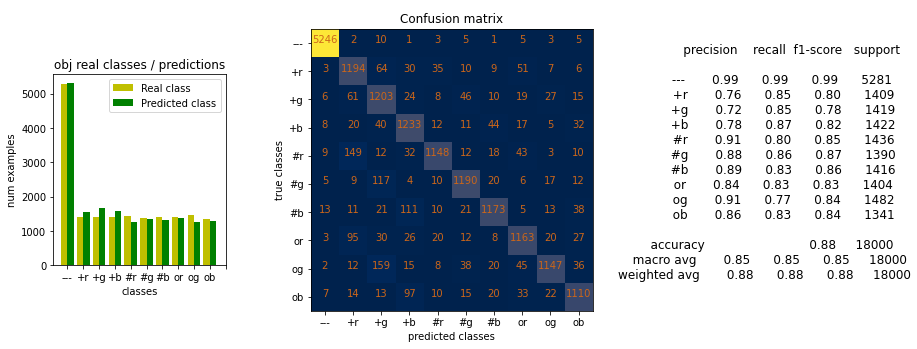

In [56]:
# MyAlexNet (48.2M params x 8 layers)
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

With AlexNet and its 88 percent overall accuracy, we get to the heart of the experiment. Non-objects are identified almost in their entirety (F1-score at .99). The histogram then shows the overestimation of some classes (in particular '+r', '+g' and '+b') compared to other underestimates (in particular '#r' and 'og'). From the confusion matrix we see a trend similar to the Test Model: the net tends to confuse shapes rather than colors - we see it in particular with the cases of crosses False Positive, most of the time it is actually the respective pounds (149 for the red, 117 for the green, 111 for the blue). It is also interesting to see that the green objects there is an overestimation of crosses also (and above all) to the detriment of squares (159 cases). The overestimates we were talking about consequently turn into the report on the right: crosses has a higher recall (and a lower precision), vice versa '#r' have the highest precision (.91) and the lowest recall (.80)

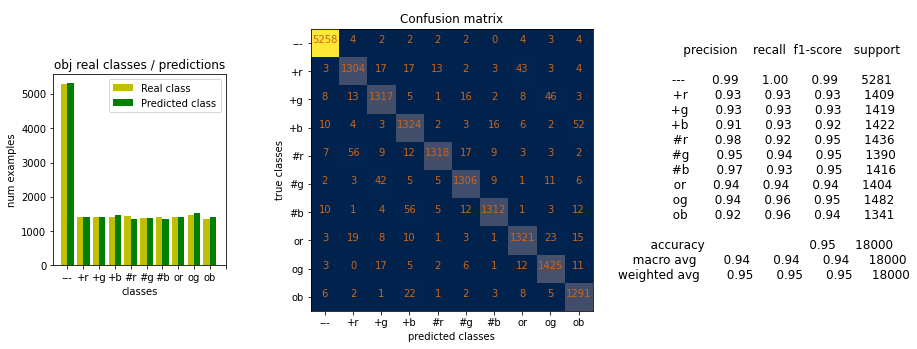

In [99]:
# VGG19 (20.4M params x 19 layers)
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

The task of evaluating results with VGG19 is more difficult. We speak of very high performances in the recognition of all classes. In the confusion matrix we can see the False Positive of the '+' in correspondence of the row of the '#', and those of the 'o' in correspondence of the '+'. A trend that we can recognize in the ability to identify pounds more easily - from the table on the right we can see the greatest precision achieved by the '#', which are also followed by very high F1_scores. On the other hand, squares have an higher average recall. The neural network probably performs better than my eye - with some color gradations I find it difficult to distinguish the shapes of objects. For a more accurate analysis (which goes beyond this experiment) it would be appropriate to carry out an error analysis by manually observing the errors committed by the network.

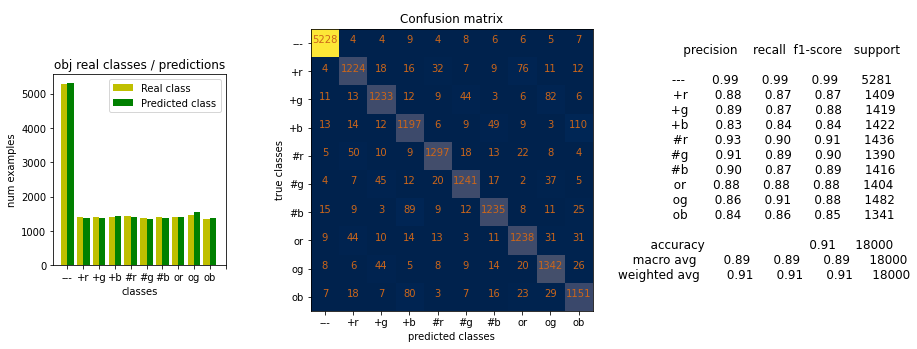

In [120]:
# Resnet152V2 (58.7M params x 152 layers)
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

With the ResNet we are back to having more leeway - with an overall accuracy of .91 we have about 9 out of a hundred wrong predictions. Non-objects are still very well identified (almost 99 percent of cases). Once again the net tends to confuse shapes rather than colors: the greatest number of False Positives are found among the 'ob' (110 cases at the expense of the '+b'), then followed by the '+b' (89 cases at the expense of the '#b' and 80 cases at the expense of the 'ob') and among the 'og' (82 cases at the expense of the '+g'). Looking at the report on the right, this trends is actually confirmed: among the three shapes, the objects with lower precision and recall values are the blue ones; furthermore we have the greatest recall for the 'og'. We would actually have to observe also the tendentially low values of cross-objects - with the '+b' which are by far the least recognized objects.

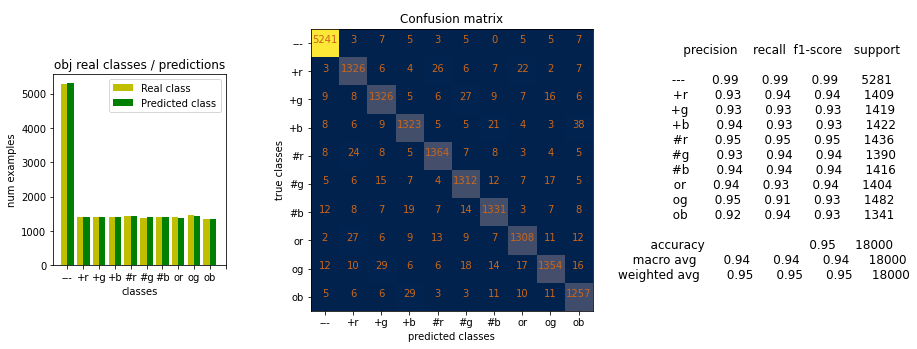

In [142]:
# DenseNet201 (7.2M params x 201 layers)
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

The results of DenseNet are uniform. There seem to be no colors or shapes of the objects for which the neural network shows greater difficulties. The most deceptive case sees 38 '+b' incorrectly classified as 'ob'. The feeling is that having a larger training set the network can further improve the already excellent performances. It is a result that, although in line with the VGG19, appears to be better precisely because it does not have any weak points.

## Coordinates predictions


Let now introduce a metric that we have not yet considered but which will be decisive for understanding the accuracy in the detection of bounding boxes. We are talking about the IoU (**Intersection over Union**) which connects the intersection bounding boxes area between objects predicted and real objects with the union of the two respective bounding boxes areas.

In [0]:
def IoU(box1, box2):
  '''  
  Arguments:
  box1 -- first box, with coordinates (x, y, w, h)
  box2 -- second box, with coordinates (x2, y2, w2, h2)
  
  Returns:
  iou -- scalar
  '''    
  [x, y, w, h] = box1
  [x2, y2, w2, h2] = box2
  # Intesection area 
  xi1 = np.maximum(x, x2)
  yi1 = np.maximum(y, y2)
  xi2 = np.minimum(x+w, x2+w2)
  yi2 = np.minimum(y+h, y2+h2)
  xi = np.maximum(0., xi2-xi1)
  yi = np.maximum(0., yi2-yi1)
  
  inter_area = np.multiply(xi,yi)

  # Union area
  box1_area = (w*h)
  box2_area = (w2*h2)
  union_area = box1_area+box2_area-inter_area
  
  # Calculation of IoU
  iou = inter_area/max(union_area, 1e-9)
  return iou

In [0]:
# The average IoU of the whole dataset
def mean_IoU(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, n_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, n_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  
  expe = expe_bboxes.reshape(-1,6)
  pred = pred_bboxes.reshape(-1,6)
  total_bb = expe.shape[0] 

  iou_global = 0
  real_bb = 0
  for i in range(total_bb):
    [eCl, _, x , y, w, h] = expe[i, :] 
    [cl, _, x2, y2, w2, h2] = pred[i, :]  
    if cl == 0:
      pass
    else: 
      iou_global += IoU([x,y,w,h], [x2,y2,w2,h2])
      real_bb += 1

  iou_global /= real_bb
  return iou_global

We add a further (more loose) evaluation metric: that is, we evaluate whether the center of our real objects is in the bounding boxes predicted by the neural network.

In [0]:
# The average center of the object in bounding box accuracy of the whole dataset 
def accuracy_centre(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, N_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, N_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  
  expe = expe_bboxes.reshape(-1,6)
  pred = pred_bboxes.reshape(-1,6)
  total_bb = expe.shape[0] 

  acc_global = 0
  real_bb = 0
  for i in range(total_bb):
    [cl, _, x , y, w, h] = expe[i, :] 
    [eCl, _, x2, y2, w2, h2] = pred[i, :]  
    if eCl == 0:
      pass
    else: 
      centreX = x+(w/2)
      centreY = y+(h/2)
      real_bb += 1
      acc_global += (x2 < centreX < x2+w2) and (y2 < centreY < y2+h2)

  acc_global /= real_bb

  return acc_global

In [192]:
# concatenate reshaped predictions to use during visualization
pred_bboxes = np.concatenate((predict_class, predict_confidence, predict_bboxes), 2)

# reshaped expected bboxes of our Validation set
expe_bboxes = Y_test.reshape(n_examples, n_bb, -1)

# check equivalence of their dimension
pred_bboxes.shape, expe_bboxes.shape

((6000, 3, 6), (6000, 3, 6))

*A clarification: the two metrics that we are adopting only evaluate the objects for which a confidence value of '1' has been predicted - taking into account also the objects with confidence equal to '0' the results however vary by a few decimal percentages.*

In [0]:
# mean IoU and accuracy center of all Test set 
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
m_acc = accuracy_centre(expe_bboxes, pred_bboxes)

Let's see how the models behave in this task, largely decisive for our experiment.

In [194]:
# Random Model (random predictions - no params x no layers)
print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Test-set mean IoU is:        0.008115111358878085
Test-set mean xy-center Acc: 0.08291021671826625 



Predicting four continuous numerical values in relation to each other is quite unlikely and as expected the Random Model does not provide noteworthy results - far from it. The 0.008 of average IoU and the 0.083 of xy-center average depend on the fact that the dimensions of the predicted bounding boxes can be quite large and incorporate the real bounding boxes while not providing real indications about the objects in the image. 

In [181]:
# Test (not a real model - 602 params x 2 layers)
print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Test-set mean IoU is:        0.06999635232080356
Test-set mean xy-center Acc: 0.1216770740410348 



The Test model doesn't actually do much better. It does slightly better in the detection of the IoU which rises to about 0.07 (and we will see later what this means). It identifies the center of the object in 12 percent of cases, all in all, not too far from the random model.

In [74]:
# MyAlexNet (48.2M params x 8 layers)
print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Test-set mean IoU is:        0.5160307886449698
Test-set mean xy-center Acc: 0.8313907702000315 



With AlexNet we are taking a decisive step forward. In 83 percent of cases the predicted bounding boxes incorporate the center of the object sought. Furthermore, our IoU goes up to 0.516, a remarkable progress: it means that on average the predicted bounding box covers at least more than half of the object sought.

In [64]:
# VGG19 (20.4M params x 19 layers)
print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Test-set mean IoU is:        0.6673312850660594
Test-set mean xy-center Acc: 0.9480693459416863 



As we expected, the VGG19 does even better and identifies the center of the object in about 94.8% of cases. The IoU rises to 0.667, an already quite high value.

In [56]:
# Resnet152V2 (58.7M params x 152 layers)
print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Test-set mean IoU is:        0.663624116316576
Test-set mean xy-center Acc: 0.943683049779458 



With ResNet we are at the level of VGG19, perhaps a very little less: but we can still say that on these metrics they behave the same way.

In [0]:
# DenseNet201 (7.2M params x 201 layers)
print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Test-set mean IoU is:        0.6973079881331878
Test-set mean xy-center Acc: 0.9505317053958251 



DenseNet performs better, not so much in identifying the center of the object that is more or less in line with the two previous neural networks, but rather in the IoU almost at 0.7.


But let's see what these results mean in practice.


##More in detail

We define a method for displaying images with objects and respective bounding boxes. 

We also put the expected data into a table for quick review.

In [0]:
def visualize_predictions(n_visual, rand_examples, iou_tr, imgTest, pred_bboxes, expe_bboxes):
    '''
    Arguments:
    ax -- plot image
    img -- np.array(side_dim,side_dim,3), an image
    bboxes -- np.array(n_bb,6), predicted bounding boxes
    expe_bboxes -- np.array(n_bb,6), expected bounding boxes
    iou_tr -- scalar, IoU treshold

    Returns:
    None
    '''
    # image side dimension
    side_dim = imgTest.shape[1]

    # number of bounding boxes
    n_bb = pred_bboxes.shape[1]

    # show predictions
    fig = plt.figure(figsize=(18,8))
    for i in range (n_visual):
      
      # We take a random image of our training set
      im = rand_examples[i]
      ax = fig.add_subplot((n_visual//4)+1,4, i+1)
      ax.grid( which='both', color='w', linestyle=':')
      plt.xticks(np.arange(0, side_dim, step=10))
      ax.set_title('Imagine n.' + str(im))

      img = imgTest[im]
      pred = pred_bboxes[im]
      expe = expe_bboxes[im]

      # We look at the objects contained in it...
      ax.imshow(img, origin='upper', extent=[0, side_dim, side_dim, 0])

      # ...and the bounding boxes predicted by the algorithm
      print(' _______________________________________________________________ ')
      print('| Image:{0:6d}                   |       expected/predicted     |'.format(im))
      for j in range(n_bb):
          [Cl, Pc, x, y, w, h] = pred[j]
          Cl = classes[int(round(Cl))]
          Pc = int(round(Pc))
          

          [eCl, ePc, x2, y2, w2, h2] = expe[j, :]
          eCl = classes[int(round(eCl))]
          ePc = int(round(ePc))
          iou_bb = IoU([x, y, w, h], [x2, y2, w2, h2])
          
          if Pc == 0:
            rect = patches.Rectangle((x, y), w, h, ec='tab:blue', lw='1.4', fc='none')
          else:
            if iou_bb >= iou_tr:
                rect = patches.Rectangle((x, y), w, h, ec='tab:red', lw='1.4', fc='none')
                dida = 'IoU: ' + '{:0.3f} '.format(iou_bb)
                plt.annotate(dida + Cl, (x + w, y + 0.8), color='tab:red')

            else:
                rect = patches.Rectangle((x, y), w, h, ec='tab:green', lw='1.4', fc='none')

          ax.add_patch(rect)
          print('| Object bounding Box IoU: {0:5.1%} | confidence {1:1d}/{2:1d} | class {3}/{4} |'.format(iou_bb, ePc, Pc, eCl, Cl))
    plt.show()

In [0]:
# Image decoding from normalized dataset
imgTest = ((np.reshape(X_test, (n_examples, side_dim, side_dim, 3)) * imgs_std) + imgs_mean)/255

In [0]:
# Internent over Union treshold to consider valid Bounding Boxes
iou_tr = .3

# We look at n_visual random images of our Validation set and at the bounding boxes predicted by the algorithm
n_visual = 3

# take n_visual random examples
rand_examples = np.random.randint(n_examples, size = (n_visual,))


> *** We use the same random examples that we got the first time to compare the behavior of the different models


In [0]:
# Same random examples for all models***  
rand_examples = [1700, 2732, 1736]

Display bounding boxes and other predictions.

The colors of the bounding boxes indicate:
- Red: objects with confidence 1 and IoU >= iou_tr
- Green: objects with confidence 1 and IoU < iou_tr
- Blue: objects with confidence 0

Obviously the red outlines are the ones that interest us most.

 _______________________________________________________________ 
| Image:  1700                   |       expected/predicted     |
| Object bounding Box IoU:  9.0% | confidence 1/1 | class ob/+g |
| Object bounding Box IoU:  1.5% | confidence 1/0 | class +r/#b |
| Object bounding Box IoU:  0.0% | confidence 1/0 | class +r/#b |
 _______________________________________________________________ 
| Image:  2732                   |       expected/predicted     |
| Object bounding Box IoU:  0.0% | confidence 1/1 | class +b/-- |
| Object bounding Box IoU:  0.0% | confidence 1/1 | class or/-- |
| Object bounding Box IoU:  0.0% | confidence 0/0 | class --/#b |
 _______________________________________________________________ 
| Image:  1736                   |       expected/predicted     |
| Object bounding Box IoU:  0.0% | confidence 1/1 | class #r/og |
| Object bounding Box IoU:  0.0% | confidence 1/0 | class og/#g |
| Object bounding Box IoU:  0.0% | confidence 1/1 | class ob/+r |


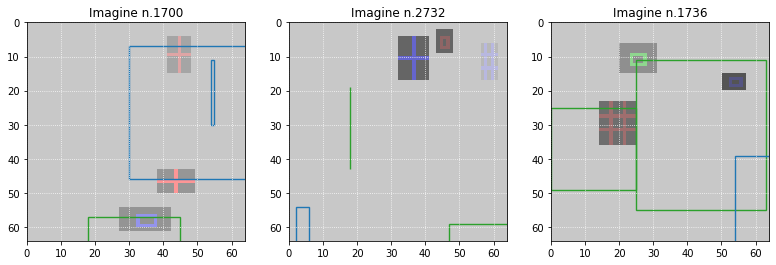

In [195]:
# Random Model (random predictions - no params x no layers)
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

Our Random Model has no rules, if not just randomness - deliberately we have not placed constraints even on the creation of bounding boxes whose dimensions can go beyond the image. This, as we have already seen, translates in the ability to identify the center of the object in over 8 percent of cases. But as we can see, the predictions are really poor. 

 _______________________________________________________________ 
| Image:  1700                   |       expected/predicted     |
| Object bounding Box IoU:  0.0% | confidence 1/1 | class ob/ob |
| Object bounding Box IoU:  0.0% | confidence 1/0 | class +r/or |
| Object bounding Box IoU:  0.0% | confidence 1/0 | class +r/-- |
 _______________________________________________________________ 
| Image:  2732                   |       expected/predicted     |
| Object bounding Box IoU:  0.0% | confidence 1/1 | class +b/og |
| Object bounding Box IoU:  0.0% | confidence 1/1 | class or/#b |
| Object bounding Box IoU:  0.0% | confidence 0/0 | class --/-- |
 _______________________________________________________________ 
| Image:  1736                   |       expected/predicted     |
| Object bounding Box IoU: 28.6% | confidence 1/1 | class #r/or |
| Object bounding Box IoU:  0.0% | confidence 1/1 | class og/+r |
| Object bounding Box IoU:  0.0% | confidence 1/0 | class ob/-- |


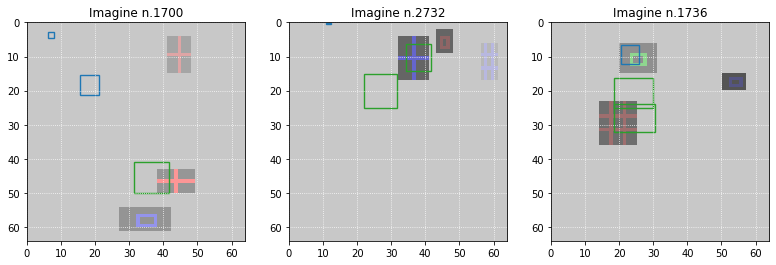

In [186]:
# test (Flat model - not a CNN - 602 params x 2 layers)
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

Our Test model are still scarce but not poor as in the previous case. Leaving aside the abundance of blue, which denotes the poor performance achieved in the confidence task, let's take a look only at the quality of the frames. We can recognize that the bounding boxes seem to have a correct orientation with respect to the objects present in the images. This corresponds to the slight increase in the average IoU to 0.069 compared to the random model. In the second image the object '+b' seems to be centered on the prediction, alas the bounding box that frames it however belongs to the object next to it (the 'or').

 _______________________________________________________________ 
| Image:  1700                   |       expected/predicted     |
| Object bounding Box IoU: 12.3% | confidence 1/0 | class ob/+b |
| Object bounding Box IoU: 32.2% | confidence 1/1 | class +r/+r |
| Object bounding Box IoU: 52.2% | confidence 1/1 | class +r/+r |
 _______________________________________________________________ 
| Image:  2732                   |       expected/predicted     |
| Object bounding Box IoU: 69.8% | confidence 1/1 | class +b/+b |
| Object bounding Box IoU: 11.1% | confidence 1/1 | class or/+b |
| Object bounding Box IoU:  0.0% | confidence 0/0 | class --/-- |
 _______________________________________________________________ 
| Image:  1736                   |       expected/predicted     |
| Object bounding Box IoU: 63.2% | confidence 1/0 | class #r/#r |
| Object bounding Box IoU: 81.2% | confidence 1/1 | class og/og |
| Object bounding Box IoU: 61.6% | confidence 1/1 | class ob/ob |


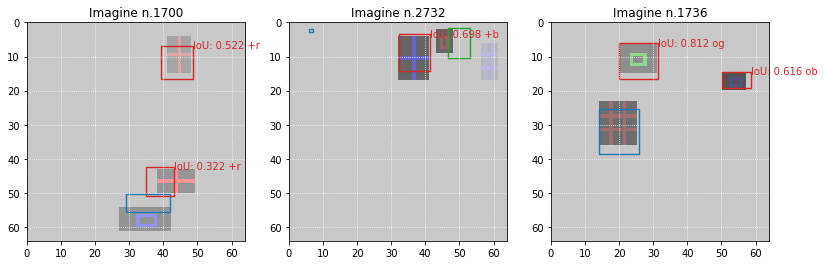

In [73]:
# MyAlexNet (48.2M params x 8 layers)
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

With AlexNet we have a significant improvement over previous models. The bounding boxes are all correctly oriented and mostly identify a substantial part of the object. The second image in particular contains a non-object (an object that in the creation phase of the examples we considered not to be detected because of a color that differs too little from the background). The model does not seem to recognize its presence as a non-object and cretes a little blue frame on the top left. On the other hand, the central green frame seems to be affected by the presence of the non-object. We also see blue frames in the first and third images: in these cases the neural network has identified the objects it frames as non-objects. From the point of view of the coordinates, however, we can say that the improvement is remarkable and in the third image all the objects are identified quite well - one even with an IoU of 81.2%. 

 _______________________________________________________________ 
| Image:  1700                   |       expected/predicted     |
| Object bounding Box IoU: 69.5% | confidence 1/1 | class ob/ob |
| Object bounding Box IoU: 52.5% | confidence 1/1 | class +r/+r |
| Object bounding Box IoU: 44.8% | confidence 1/0 | class +r/+r |
 _______________________________________________________________ 
| Image:  2732                   |       expected/predicted     |
| Object bounding Box IoU: 59.4% | confidence 1/1 | class +b/+b |
| Object bounding Box IoU: 58.6% | confidence 1/1 | class or/+r |
| Object bounding Box IoU:  0.0% | confidence 0/1 | class --/-- |
 _______________________________________________________________ 
| Image:  1736                   |       expected/predicted     |
| Object bounding Box IoU: 78.2% | confidence 1/1 | class #r/#r |
| Object bounding Box IoU: 66.2% | confidence 1/1 | class og/og |
| Object bounding Box IoU: 48.5% | confidence 1/1 | class ob/ob |


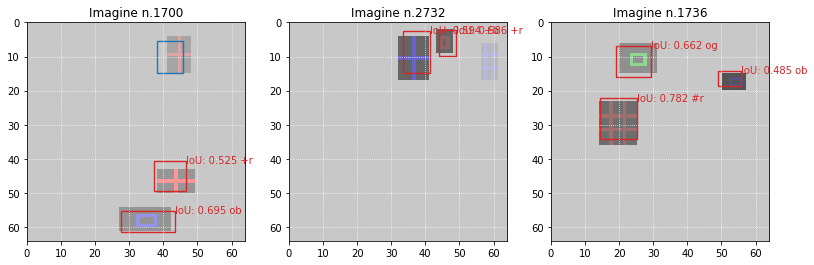

In [26]:
# VGG19 (20.4M params x 19 layers)
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

With the VGG19 all the objects are correctly framed, and this is what presses us in this part of the experiment. So we do not dwell on the object framed by a blue boxing bounding in the first image. Compared to AlexNet, the quality of the boxes is generally better, the IoU oscillates between 44.8% and 78.2%.If we are to be critical, we can begin to reason about the quality of bounding boxes that are good but not accurate. But this is a problem that requires a further step in the construction of the model (even if only with the increase in examples).

 _______________________________________________________________ 
| Image:  1700                   |       expected/predicted     |
| Object bounding Box IoU: 32.8% | confidence 1/1 | class ob/+r |
| Object bounding Box IoU: 12.3% | confidence 1/1 | class +r/+r |
| Object bounding Box IoU: 27.0% | confidence 1/1 | class +r/+r |
 _______________________________________________________________ 
| Image:  2732                   |       expected/predicted     |
| Object bounding Box IoU: 61.7% | confidence 1/1 | class +b/+b |
| Object bounding Box IoU: 13.2% | confidence 1/1 | class or/or |
| Object bounding Box IoU:  0.0% | confidence 0/1 | class --/-- |
 _______________________________________________________________ 
| Image:  1736                   |       expected/predicted     |
| Object bounding Box IoU: 86.0% | confidence 1/0 | class #r/#r |
| Object bounding Box IoU: 73.9% | confidence 1/1 | class og/og |
| Object bounding Box IoU: 82.7% | confidence 1/1 | class ob/ob |


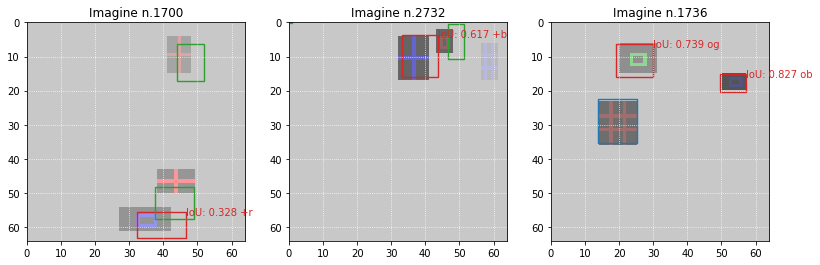

In [35]:
# Resnet152V2 (58.7M params x 152 layers')
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

the performances of the ResNet are fluctuating: the objects are all somewhat framed. It is surprising to see how well-centered objects have a decidedly high quality - especially those of the third image better than the VGG19. Vice versa we see that where the net does not center the object the bounding boxes are decidedly not very accurate - as shown by the green frames of the first and second images. The impression is once again that the potential of this neural network has not been expressed, either due to the scarcity of the examples, or due to an inadequate hyperparameter tuning.

 _______________________________________________________________ 
| Image:  1700                   |       expected/predicted     |
| Object bounding Box IoU: 64.5% | confidence 1/1 | class ob/ob |
| Object bounding Box IoU: 45.5% | confidence 1/1 | class +r/+r |
| Object bounding Box IoU: 49.1% | confidence 1/1 | class +r/+r |
 _______________________________________________________________ 
| Image:  2732                   |       expected/predicted     |
| Object bounding Box IoU: 68.9% | confidence 1/1 | class +b/+b |
| Object bounding Box IoU: 30.9% | confidence 1/1 | class or/+b |
| Object bounding Box IoU:  0.0% | confidence 0/0 | class --/-- |
 _______________________________________________________________ 
| Image:  1736                   |       expected/predicted     |
| Object bounding Box IoU: 83.5% | confidence 1/0 | class #r/#r |
| Object bounding Box IoU: 64.9% | confidence 1/1 | class og/og |
| Object bounding Box IoU: 77.9% | confidence 1/1 | class ob/ob |


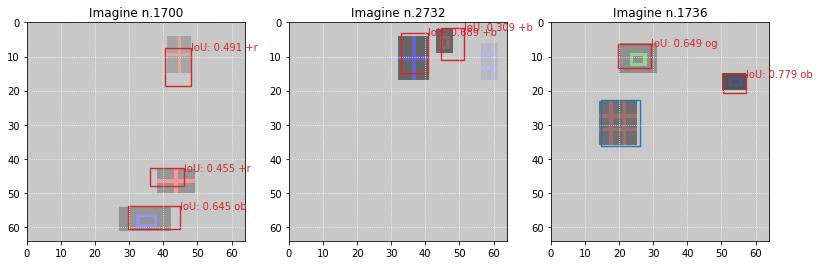

In [48]:
# DenseNet201 (7.2M params x 201 layers)
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

DenseNet performs quite well, leaving aside the confidence error in the last image (a problem that, as I said, does not interest us in this phase of the experiment and in which, however, all the models except for the ResNet ran). The quality of the boxes is generally high, the IoU oscillates between 30.9% and 83.5%. We have the lowest IoU in the second image (the green frame). In this case, as for AlexNet (but also ResNet), the impression is that the non-object on the right somehow 'disturbs' the correct detection of the object.

##Conclusions

The intention of this work was to test different neural networks taken from the scientific literature in the solution of the same task. The idea was to build the entire experiment pipeline so that it could be replicated and expanded to act as a skeleton for future testing applications. In addition, there was a desire to better understand the functioning of the neural networks examined.

The construction of the dataset of examples took some time, and during the realization of other phases of the experiment I had to go back to my steps to specify the shape and other characteristics of the examples - in particular the final choice of having images sized 64x64 and to create 3 bounding boxes for each image has matured as a balance between various needs, not least that of saving memory space.

The second phase, in some ways the most delicate, was deliberately the least thorough from an analysis point of view. The greatest difficulties concern the construction of the three heads of each of the neural networks and in particular the definition of the loss functions. The training took a long time, especially for the correct setting of the hyperparameters and the evaluation of the appropriate dimensions for the training dataset: initially I had opted for a larger dataset obtaining decidedly high overall results, but the performance of VGG19, ResNet and DenseNet were too good to be able to identify in more detail the characteristics intrinsic to the networks and to make a comparison between them - hence the decision to reduce the training / validation-set to 16 thousand examples, keeping the Test-set consisting of 6 thousand examples oversized. 

The difficulties in the analysis phase mainly concerned the way of 'viewing' the results obtained avoiding a cold list of numerical data. The structure of this third part therefore followed a scheme in which I indicated the main reference metric and unfolded its meaning through the help of graphs, tables and images. The evolution of techniques related to the use of neural networks in the field of computer vision emerged in some way and at least in part, in particular the great step forward marked by the use of CNN and AlexNet in 2012, and then since 2014 the rapid imposition and diffusion of some of the models still widely used today - VGG, ResNet and DenseNet. The latter three, in particular, provide high results but have different characters which I hope at least in part to have brought to light with this discussion.

Finally, I hope this work will be of help to others.